# Brain MRI Stroke Classification 
## Transfer Learning Visual Geometry Group (VGG) 16 layers model 

## Set up

### Modules

#### Published modules

In [1]:
# Data Manipulation
import numpy as np

# Machine Learning
## Training, validation and test sets
from sklearn.model_selection import train_test_split

# PyTorch
## Data loading
from torch.utils.data.dataloader import DataLoader
## Pre-processing
from torchvision import transforms
## Neural Network Architecture
import torch
import torch.nn as nn
## Transfer learning
from torchvision import models
from torchvision.models import VGG16_Weights
## Optimisiation
from torch.optim import Adam
## Misc
from torchsummary import summary
from torch_snippets import show, inspect

# Utilities
## os
import os
import sys
## Paths
from pyhere import here
from glob import glob
## Garbage colector
import gc

#### Project specific modules

In [2]:
path_to_project_modules = os.path.join(here('Src','Modules'))
sys.path.insert(0, path_to_project_modules)

from Project.datautils import StrokeImageData # Class inheriting from torch.utils.data.dataset.Dataset to load images
from Project.visualisation import display_image_samples
from Project.architecture import convolution_layer # A set of layers comprised of Conv2d, RelU activation, Batch Normalisation and Maxpool
from Project.modeltraining import train_model, evaluate_model

### File paths

In [3]:
raw_data = os.path.join(here('Data', 'Raw')) #os.path.join transforms the output of pyhere.here from PosixPath to a text string
file_paths = glob(raw_data + '/*/*')

#### Random state

In [4]:
rand_state = 13 # For replication purposes
torch.manual_seed(rand_state)

#### PyTorch Backend

In [5]:
# Ensure the workflow is device agnostic 
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'Using {device} as Hardware Accelerator')

Using cuda as Hardware Accelerator


## Analysis

### Data loading and preparation

#### Data pre-processing

In [6]:
preproc_recipe = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#### Train, validation and test sets

In [7]:
# Store classes in a list (for stratification)
y = [_file_path.split('/')[-2] for _file_path in file_paths]

# Generate Training and test sets
X_trainval, x_test, y_trainval, _ = train_test_split(file_paths, y, test_size=0.2, shuffle=True, stratify=y, random_state=rand_state)

# Further split training set into training and validation sets
X_train, X_val = train_test_split(X_trainval, test_size = 0.2, shuffle=True, stratify=y_trainval, random_state=rand_state)

#### Data loading

In [8]:
strk_train = StrokeImageData(X_train, device = device, recipe = preproc_recipe)
strk_val = StrokeImageData(X_val, device = device, recipe = preproc_recipe)
strk_test = StrokeImageData(x_test, device = device, recipe = preproc_recipe)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

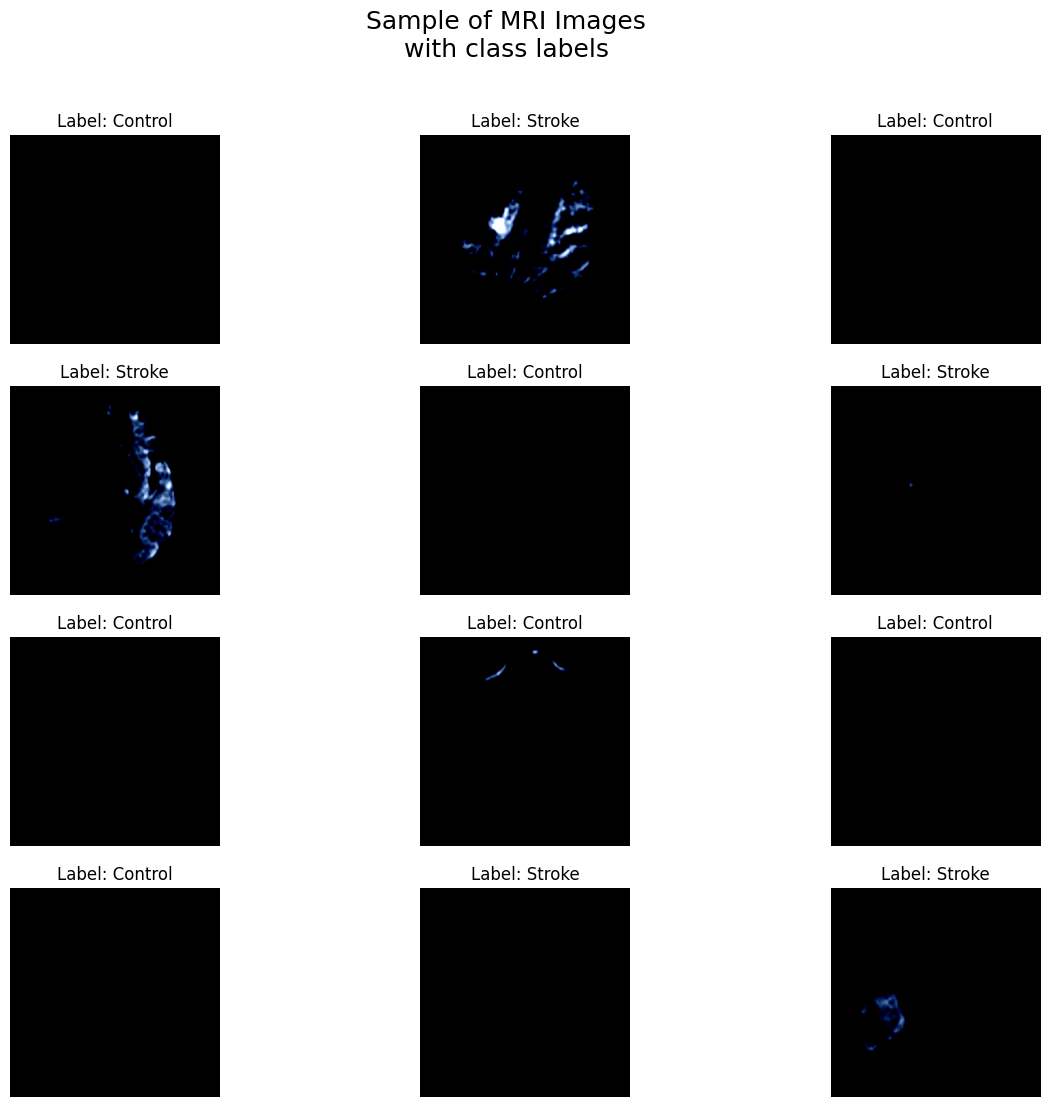

In [9]:
# Check Images are loaded correctly
display_image_samples(strk_train)

#### Data loaders

In [10]:
batch_size = 32

train_dl = DataLoader(strk_train, batch_size = batch_size, shuffle = True, drop_last = True) # Drop last batch as it only contains 6 images

val_dl = DataLoader(strk_val, batch_size = batch_size, shuffle = True, drop_last = True) # Drop last batch as it only contains 2 images

test_dl = DataLoader(strk_test, batch_size = batch_size, shuffle = True, drop_last = False)

### Model specification

#### Network Architecture

In [11]:
m_vgg16 = models.vgg16(weights=VGG16_Weights.DEFAULT).to(device)

# Freeze model parameters
for param in m_vgg16.parameters():
    param.requires_grad = False

# Update the avgpool layer
m_vgg16.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))

# Update classifier layer
m_vgg16.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(128,1),
    nn.Sigmoid()
).to(device)

In [12]:
summary(m_vgg16, input_size=(3,224, 224), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

### Hyperparameters

#### Epochs

In [13]:
n_epochs = 50

#### Optimiser

In [14]:
optim = Adam
lr = 1e-4

# learning rate annealing
scheduler_kws = {
    'factor':0.5, 
    'patience':0, 
    'threshold':1e-3, 
    'verbose':True, 
    'min_lr':1e-5, 
    'threshold_mode':'abs'}

# Early stop
earlystop_kws = {
    'patience': 5,
    'min_delta': 1e-3
}

#### Loss Function

In [15]:
loss_fn = nn.BCELoss() # Binary Cross Entropy

#### Model training

Learning rate annealing enabled...
Early stop enabled...
Epoch: 1;
Training accuracy: 58.98%, Training loss: 0.68350 ---------- Validation accuracy: 59.69%, Validation loss: 0.67711
Epoch: 2;
Training accuracy: 64.14%, Training loss: 0.66868 ---------- Validation accuracy: 62.19%, Validation loss: 0.66467
Epoch: 3;
Training accuracy: 68.91%, Training loss: 0.65416 ---------- Validation accuracy: 68.75%, Validation loss: 0.65050
Epoch: 4;
Training accuracy: 69.61%, Training loss: 0.63873 ---------- Validation accuracy: 69.06%, Validation loss: 0.63691
Epoch: 5;
Training accuracy: 70.55%, Training loss: 0.62524 ---------- Validation accuracy: 70.31%, Validation loss: 0.62442
Epoch: 6;
Training accuracy: 73.28%, Training loss: 0.60806 ---------- Validation accuracy: 70.31%, Validation loss: 0.60944
Epoch: 7;
Training accuracy: 72.81%, Training loss: 0.59552 ---------- Validation accuracy: 69.06%, Validation loss: 0.59866
Epoch: 8;
Training accuracy: 72.73%, Training loss: 0.57931 --------

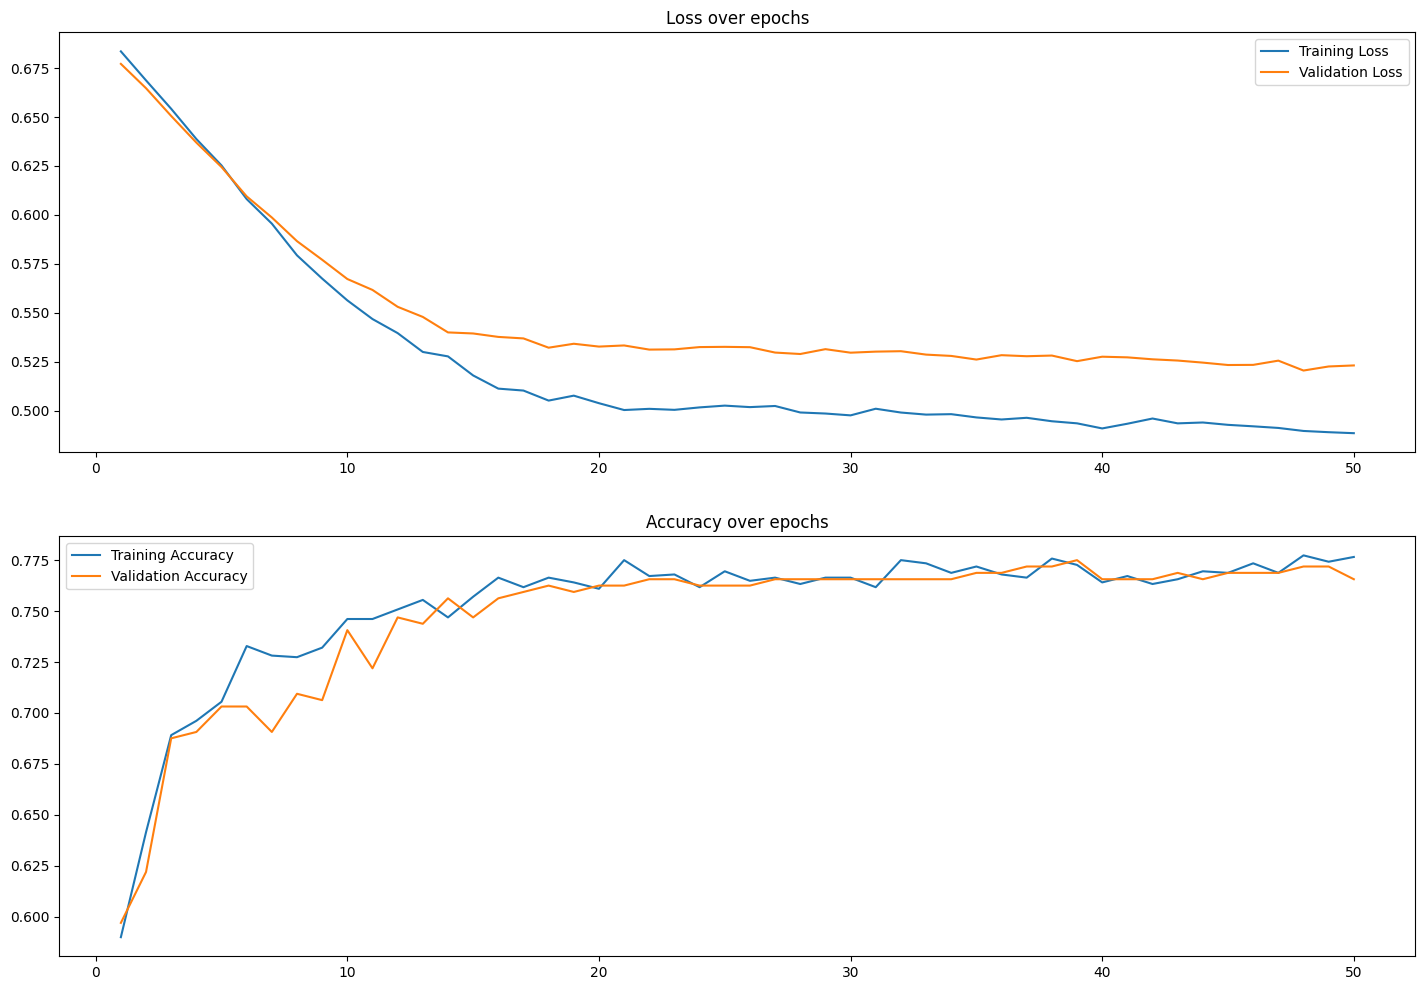

In [16]:
train_model(train_dl, val_dl, m_vgg16, loss_fn, optim, lr, n_epochs, kws_lr_scheduler = scheduler_kws, kws_early_stop = earlystop_kws)

## Performance in the Test set

In [17]:
test_acc, test_loss = evaluate_model(test_dl, m_vgg16, loss_fn, 0.5)
print(f"Test data:\n  Accuracy: {test_acc*100:.2f}%\n  Loss:    {test_loss:.5f}")

Test data:
  Accuracy: 78.36%
  Loss:    0.48985
